# Shapley value
- https://datanetworkanalysis.github.io/2019/12/23/shap1
- https://moondol-ai.tistory.com/376
- Shapley value는 서로 다른 특성들의 조합으로 얻은 예측값에 대한 해당 특성(기여도를 알고싶은 특성)의 **기여도**를 평균하여 계산한 값
- 게임이론을 바탕으로 게임에서 각 플레이어의 **기여도**를 계산, 하나의 특성에 대한 중요도를 알기 위해 여러 특성들의 조합을 구성하고 해당 특성의 유무에 따른 평균적인 변화를 통해 얻어낸 값

In [1]:
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
names = [
    'age', 'workclass', 'fnlwgt', 'education',
    'education-num', 'marital-status', 'occupation',
    'relationship', 'race', 'gender', 'capital-gain',
    'capital-loss', 'hours-per-week', 'native-country',
    'salary'
]
dtypes = {
    'workclass': 'category',
    'education': 'category',
    'marital-status': 'category',
    'occupation': 'category',
    'relationship': 'category',
    'race': 'category',
    'gender': 'category',
    'native-country': 'category'
}

X = pd.read_csv(url, names=names, header=None, dtype=dtypes)
X['gender'] = X['gender'].str.strip().astype('category')  # Remove leading whitespace

In [2]:
from sklearn.preprocessing import OrdinalEncoder

# categorical = list(dtypes.keys())
categorical = [col for col in X.columns if X.dtypes[col] == 'category']

oe = OrdinalEncoder()
X_oe = pd.DataFrame(oe.fit_transform(X[categorical]), columns=categorical)
X[categorical] = X_oe

y = X.pop('salary').map({' <=50K': 0, ' >50K': 1})

X.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,39,7.0,77516,9.0,13,4.0,1.0,1.0,4.0,1.0,2174,0,40,39.0
1,50,6.0,83311,9.0,13,2.0,4.0,0.0,4.0,1.0,0,0,13,39.0
2,38,4.0,215646,11.0,9,0.0,6.0,1.0,4.0,1.0,0,0,40,39.0
3,53,4.0,234721,1.0,7,2.0,6.0,0.0,2.0,1.0,0,0,40,39.0
4,28,4.0,338409,9.0,13,2.0,10.0,5.0,2.0,0.0,0,0,40,5.0


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

## 학습

In [4]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

pred = xgb.predict(X_test)

C:\Users\dongwha\Anaconda3\envs\py39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:49:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [5]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_test, pred)
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8649


In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=135)
rf.fit(X_train, y_train)

pred2 = rf.predict(X_test)

acc = accuracy_score(y_test, pred2)
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8524


## shap
- SHapley Additive exPlanations

### `explainer`
- https://moondol-ai.tistory.com/378
- `TreeExplainer`: 트리 계열 모델에 사용
- `KernelExplainer`: 모든 모델에 사용 가능하지만 속도가 느림, 정확한 값 대신 추정값을 냄
- `DeepExplainer`: 딥러닝 모델에 사용

### 개별 row
- XGBoost
    - 전체 테스트 데이터에 대해 shapley value를 계산한 뒤 plot 단계에서 row 선택
- RandomForest
    - 특정 데이터에 대해 shapley value를 계산, plot

In [40]:
row_to_show = 10
X_test.iloc[[row_to_show]]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
12227,21,4.0,204596,7.0,12,4.0,1.0,3.0,4.0,0.0,0,0,8,39.0


### `force_plot()`, `waterfall_plot()`
- 기준 값을 사용했을 때와 비교하여 예측값을 해석

#### XGBoost의 SHAP 주의점
- https://github.com/slundberg/shap/issues/350
- XGBoost, Catboost 등의 알고리즘은 `binary:logistic`을 사용하기 때문에, 비록 예측값이 0과 1 사이더라도 shap value가 음수가 나올 수 있음

In [41]:
import shap

# XGB
explainer = shap.TreeExplainer(xgb)
shap_values = explainer(X_test)
# shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [43]:
shap.initjs()
shap.force_plot(shap_values[row_to_show])
# shap.plots.force(shap_values[row_to_show])

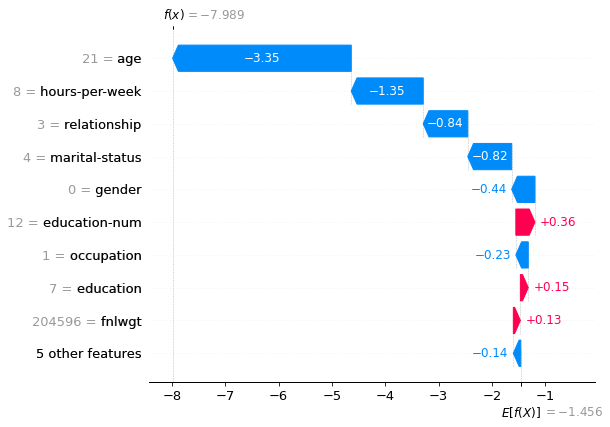

In [44]:
shap.waterfall_plot(shap_values[row_to_show])
# shap.plots.waterfall(shap_values[row_to_show])

In [45]:
xgb.predict_proba(X_test.iloc[[row_to_show]])

array([[9.9966085e-01, 3.3917598e-04]], dtype=float32)

### 해석
- 모델이 이 값을 0(음수)으로 예측한 것은 나이가 21인 영향이 가장 크다.

In [38]:
shap.initjs()
shap.force_plot(shap_values[-3])
# shap.plots.force(shap_values[row_to_show])

In [39]:
xgb.predict_proba(X_test.iloc[[-3]])

array([[2.694726e-04, 9.997305e-01]], dtype=float32)

- 반대로 1(양수)로 예측한 것은 `capital-gain`의 영향이 크기 때문이다.

#### RandomForest의 주의점
- `Classifier`의 경우 확률로 나오기 때문에 `shap_values[i]`로 선택(`i`번째 class)

In [46]:
# RF
explainer2 = shap.TreeExplainer(rf)
data_for_prediction = X_test.iloc[row_to_show]

shap_values2 = explainer2.shap_values(data_for_prediction)
# shap_values2 = explainer2(X_test) # 상당히 오래 걸리므로 추천하지 않음

In [47]:
shap.initjs()
shap.force_plot(explainer2.expected_value[1], shap_values2[1], data_for_prediction)

In [19]:
rf.predict_proba(X_test.iloc[[row_to_show]])

array([[0.52, 0.48]])

### 전체
- `plots.bar()`: 평균 |shapley value|를 계산, 각 feature가 얼마나 영향을 주었는지 확인. `summary_plot(plot_type='bar')`
- `summary_plot()`: 각 feature가 어떻게 영향을 주었는지 확인

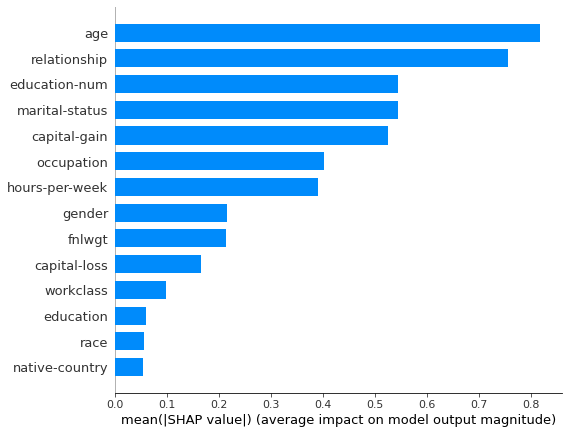

In [20]:
# shap.plots.bar(shap_values)
shap.summary_plot(shap_values, plot_type="bar")

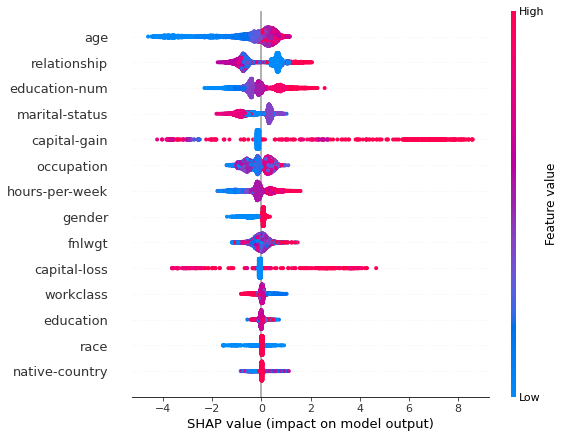

In [21]:
shap.summary_plot(shap_values)

### 해석
- `age`, `relationship` 순으로 모델에 영향을 많이 줌
- `age`는 값이 low면 모델이 0(음수)로 예측하게 됨

In [ ]:
# shap_values2 = explainer2(X_test.iloc[:1000])
# shap.summary_plot(shap_values2) #.values, X_test.iloc[:1000])

### 상호작용
- `dependence_plot()`

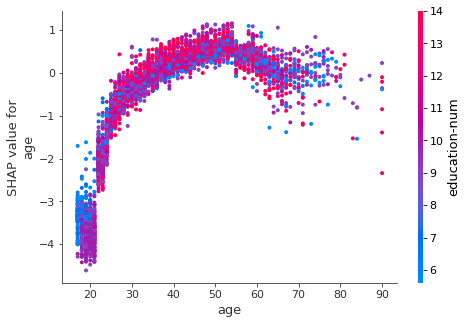

In [22]:
shap.dependence_plot("age", shap_values.values, X_test, interaction_index="education-num")